Below is a demonstration of applied [Machine learning](https://en.wikipedia.org/wiki/Machine_learning) to **identify persons of interest (POI) of the [Enron scandal](https://en.wikipedia.org/wiki/Enron_scandal)**.

(We use financial information of Enron employees to find out if they have a high potential of having been inflicted in fraud. Features - such as salary - that I think could make them interesting for this case are analysed with machine learning techniques - such as [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree). Results are then compared with an existing list of POIs.)

### Findings

- The dataset contains very few data points
- Using the 'Decision tree' algorithm we could predict POIs with low certainty (accuracy 0.67, precision 0.39, recall 0.37)

<br>

Let's go!

In [34]:
#!/usr/bin/python

### Load standard libraries:
import sys
import pickle
from time import time
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

### Load local libraries:
sys.path.append("../src/")
#from email_preprocess import preprocess
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Load dataset:
with open("../data/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

Let's explore the dataset:

In [35]:
print len(data_dict), "entries" ,'\n','\n', "with keys like:", '\n', data_dict.keys()[:4] , '\n', '\n' ,  "and these features:"
print "\n".join([str(x) for x in sorted(data_dict['METTS MARK'].keys())] )

146 entries 

with keys like: 
['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R'] 

and these features:
bonus
deferral_payments
deferred_income
director_fees
email_address
exercised_stock_options
expenses
from_messages
from_poi_to_this_person
from_this_person_to_poi
loan_advances
long_term_incentive
other
poi
restricted_stock
restricted_stock_deferred
salary
shared_receipt_with_poi
to_messages
total_payments
total_stock_value


"from poi to this person" is the number of mails coming from a person of interest. Let's create new normalized features to make use of these from and to poi emails:

In [36]:
### The new features are fraction_to_poi_email, fraction_from_poi_email

### Extract the dict elements and parse them to a list
def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

fract_from_poi_email = dict_to_list("from_poi_to_this_person","to_messages")
fract_to_poi_email = dict_to_list("from_this_person_to_poi","from_messages")

### Test if data is congruent
if len(fract_from_poi_email) == len(fract_to_poi_email) == len(data_dict):
    print "Ok"

Ok


We add them to the dataset

In [37]:
for count, i in enumerate(data_dict):
    data_dict[i]["fract_from_poi_email"] = fract_from_poi_email[count]
    data_dict[i]["fract_to_poi_email"] = fract_to_poi_email[count]

Now we can select the features for our classifiers:

In [38]:
###  All available features
features_list = [ 'poi',
                 'deferral_payments',
 'expenses',
 'deferred_income',
 'long_term_incentive',
 'restricted_stock_deferred',
 'fract_to_poi_email',
 'loan_advances',
 'director_fees',
 'bonus',
 'total_stock_value',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'restricted_stock',
 'salary',
 'total_payments',
 'fract_from_poi_email',
 'exercised_stock_options']

### Exerpt of impactful features
##features_list = ["poi", "fract_from_poi_email", "fract_to_poi_email", "shared_receipt_with_poi"]
#features_list = ["poi", "deferred_income", "deferral_payments",  "total_stock_value", "exercised_stock_options", "fract_to_poi_email", "shared_receipt_with_poi"]

In [39]:
### Remove outliers [I](See data exploration I below.)
data_dict.pop("TOTAL",0)
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

Preprocess<br>
Cross validation - split data into train and test

In [40]:
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

In [41]:
### Classification
# Note that if you want to do PCA or other multi-stage operations,
# you'll need to use Pipelines. For more info:
# http://scikit-learn.org/stable/modules/pipeline.html

###DecisionTree

In [42]:
### DecisionTree: Precision, Recall, parameter tuning
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score

# (Possibility to loop results for several runs and to plot them below)
k_range = range(1,10)
k_scores=[]
for k in k_range:
    clf = DecisionTreeClassifier(min_samples_split=k)
    score = cross_validation.cross_val_score(clf, features, labels, cv=3, scoring='recall')
    k_scores.append(score.mean())
print k_scores

[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.16666666666666666, 0.0, 0.055555555555555552, 0.0, 0.0, 0.055555555555555552]


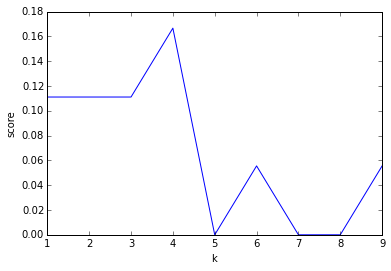

In [43]:
plt.plot(k_range, k_scores)
plt.xlabel('k')
plt.ylabel('score')

In [44]:
acc = []
pre = []
rec = []

for i in range(1,50):
    clf = DecisionTreeClassifier(min_samples_split=3)
    clf = clf.fit(features_train, labels_train)
    pred = clf.predict(features_test,labels_test)
    acc.append(accuracy_score(labels_test,pred))
    pre.append(precision_score(labels_test,pred))
    rec.append(recall_score(labels_test,pred))
    
print "Decision tree fit complete"
print "accuracy", round(np.mean(acc),2)
print "precision", round(np.mean(pre),2)
print "recall", round(np.mean(rec),2)

Decision tree fit complete
accuracy 0.67
precision 0.39
recall 0.37


#Comparison to other classifiers

We compared results with other algorithms such as RandomForest or SVC. With the low amount of input data we were not able to find substantially higher results.

# Data exploration

In [69]:
feat = pd.DataFrame(features, columns=features_list[1:])

In [70]:
import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)
qgrid.show_grid(feat)

[1] Features - identified one outlier "TOTAL"

In [71]:
bon = [count for count, i in enumerate(features_list) if i == "bonus"][0]
sal = [count for count, i in enumerate(features_list) if i == "salary"][0]

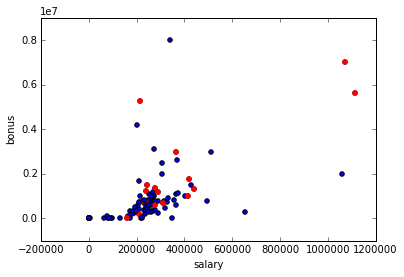

In [72]:
for point in data:
    from_poi = point[sal]
    to_poi = point[bon]
    plt.scatter(from_poi,to_poi)
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r")
plt.ylabel("bonus")        
plt.xlabel("salary")
plt.show()

In [89]:
np.round(feat.describe(),0)

,deferral_payments,expenses,deferred_income,long_term_incentive,restricted_stock_deferred,fract_to_poi_email,loan_advances,director_fees,bonus,total_stock_value,from_poi_to_this_person,from_this_person_to_poi,restricted_stock,salary,total_payments,fract_from_poi_email,exercised_stock_options
count,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144
mean,-0,-0,0,0,-0,-0,-0,-0,0,0,0,0,0,0,0,0,-0
std,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
min,-0,-1,-5,-0,-1,-1,-0,-0,-1,-0,-1,-0,-2,-1,-0,-1,-0
25%,-0,-1,0,-0,-0,-1,-0,-0,-1,-0,-1,-0,-0,-1,-0,-1,-0
50%,-0,-0,0,-0,-0,-1,-0,-0,-0,-0,-0,-0,-0,0,-0,-0,-0
75%,-0,0,0,0,-0,0,-0,-0,0,-0,0,-0,-0,0,-0,0,-0
max,8,4,0,7,12,5,12,4,6,7,7,7,7,5,11,5,7


Interactive visualization of features:

#Feature occurences

In [91]:
clfimp = clf.feature_importances_
features_new = []
for count,i in enumerate(clfimp):
    features_new.append([format(clfimp[count], '.3f'), features_list[count+1]])
pd.DataFrame(features_new,columns=['importance','feature']).sort('importance',ascending=False).reset_index(drop=True)

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

#RandomForestClassifier

In [52]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

pre = []
names = ["Random Forest"]
classifiers = [RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]
for name, clf in zip(names, classifiers):
    #ax = plt.subplot(len(features), len(classifiers)+1, i)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    score = clf.score(features_test,labels_test)
    accuracy_score(labels_test, pred)
    """acc.append(accuracy_score(labels_test,pred))
    pre.append(precision_score(labels_test,pred))
    rec.append(recall_score(labels_test,pred))
    print score
    print "accuracy", round(np.mean(acc),2)
    print "precision", round(np.mean(pre),2)
    print "recall", round(np.mean(rec),2)"""
    """
    pre=[]
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
pre.append(precision_score(labels_test,pred))
print pre"""

In [53]:
pre=[]
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
pre.append(precision_score(labels_test,pred))
print pre

[0.0]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
precision_score(labels_test, pred)

0.0

#SVC

In [56]:
from sklearn.svm import SVC
estimator = SVC(kernel='linear')
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(len(labels_train), n_iter=10, test_size=0.2, random_state=0)

In [57]:
"""from sklearn.grid_search import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)
clf.fit(features_train, labels_train)"""

"from sklearn.grid_search import GridSearchCV\nparameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}\nclf = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)\nclf.fit(features_train, labels_train)"

In [58]:
len(features_train)

129

In [59]:

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

NameError: name 'my_dataset' is not defined


### Actions taken

- Outliers
    - The financial dataset included the item "total amount of incomes". Item was removed 
- Features
    - The features salary, exercised_stock_options and total_payments showed to be most promising for ML and were selected
        - The selection process was as follows:
            - Bil
- Algorithms
    - We use 'Decision tree' and 'Linear regression'
    - Random forest?
- Parameter tuning
- Validation
    - To avoid overfitting, cross validation was applied
    - Grid search?
- Data exploration
    - plot
    - grid view

[For references](https://jaycode.github.io/enron/identifying-fraud-from-enron-email.html)